# Lasso and Ridge Regression

#### Build a multilinear regression with lasso and ridge regularization model on computer features dataset. Identify the attributes that affect the computer price.

In [75]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
comp_df = pd.read_csv(r"D:\360digi\DS\Sharath\LogisticReg2_Lasso_Ridge\handson\Datasets_LassoRidge\RetailPrices_data.csv")
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6259 entries, 0 to 6258
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6259 non-null   int64 
 1   price       6259 non-null   int64 
 2   speed       6259 non-null   int64 
 3   hd          6259 non-null   int64 
 4   ram         6259 non-null   int64 
 5   screen      6259 non-null   int64 
 6   cd          6259 non-null   object
 7   multi       6259 non-null   object
 8   premium     6259 non-null   object
 9   ads         6259 non-null   int64 
 10  trend       6259 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 538.0+ KB


In [4]:
comp_df.columns

Index(['Unnamed: 0', 'price', 'speed', 'hd', 'ram', 'screen', 'cd', 'multi',
       'premium', 'ads', 'trend'],
      dtype='object')

In [5]:
comp_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
comp_df.describe()

,price,speed,hd,ram,screen,ads,trend
count,6259.000000,6259.000000,6259.000000,6259.000000,6259.000000,6259.000000,6259.000000
mean,2219.576610,52.011024,416.601694,8.286947,14.608723,221.301007,15.926985
std,580.803956,21.157735,258.548445,5.631099,0.905115,74.835284,7.873984
min,949.000000,25.000000,80.000000,2.000000,14.000000,39.000000,1.000000
25%,1794.000000,33.000000,214.000000,4.000000,14.000000,162.500000,10.000000
50%,2144.000000,50.000000,340.000000,8.000000,14.000000,246.000000,16.000000
75%,2595.000000,66.000000,528.000000,8.000000,15.000000,275.000000,21.500000
max,5399.000000,100.000000,2100.000000,32.000000,17.000000,339.000000,35.000000


In [8]:
comp_df.isnull().sum()

price      0
speed      0
hd         0
ram        0
screen     0
cd         0
multi      0
premium    0
ads        0
trend      0
dtype: int64

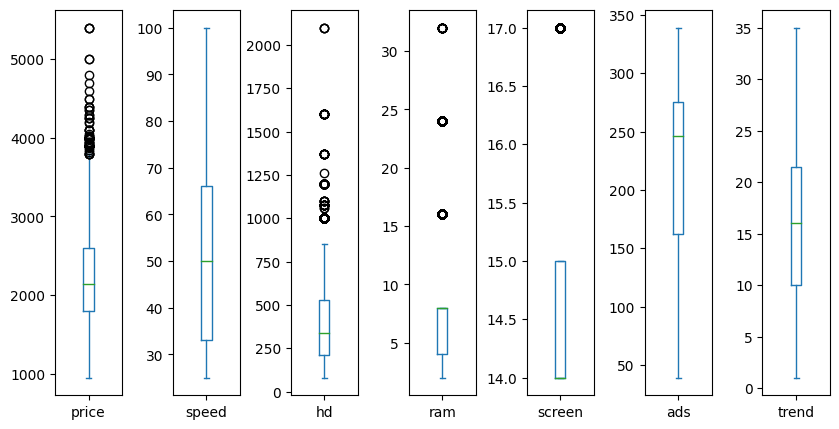

In [9]:
# box plot visualisation
comp_df.plot(kind = 'box', subplots = True, sharey = False, figsize = (10,5))
plt.subplots_adjust(wspace = 0.75)
plt.show()

In [10]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6259 entries, 0 to 6258
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   price    6259 non-null   int64 
 1   speed    6259 non-null   int64 
 2   hd       6259 non-null   int64 
 3   ram      6259 non-null   int64 
 4   screen   6259 non-null   int64 
 5   cd       6259 non-null   object
 6   multi    6259 non-null   object
 7   premium  6259 non-null   object
 8   ads      6259 non-null   int64 
 9   trend    6259 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 489.1+ KB


In [11]:
# Seperating input and output variables 
X = comp_df.iloc[:, 1:10]
X

,speed,hd,ram,screen,cd,multi,premium,ads,trend
0,25,80,4,14,no,no,yes,94,1
1,33,85,2,14,no,no,yes,94,1
2,25,170,4,15,no,no,yes,94,1
3,25,170,8,14,no,no,no,94,1
4,33,340,16,14,no,no,yes,94,1
...,...,...,...,...,...,...,...,...,...
6254,100,528,8,15,no,no,yes,39,35
6255,66,850,16,15,yes,yes,yes,39,35
6256,100,1200,24,15,yes,no,yes,39,35
6257,100,850,16,15,yes,no,yes,39,35


In [12]:
Y = pd.DataFrame(comp_df['price'])
Y

,price
0,1499
1,1795
2,1595
3,1849
4,3295
...,...
6254,1690
6255,2223
6256,2654
6257,2195


# Data Preprocessing

In [13]:
# Select numeric features for data preprocessing
numeric_features = X.select_dtypes(exclude = ['object']).columns
print(numeric_features)

Index(['speed', 'hd', 'ram', 'screen', 'ads', 'trend'], dtype='object')


In [14]:
categorical_features = X.select_dtypes(include = ['object']).columns
print(categorical_features)

Index(['cd', 'multi', 'premium'], dtype='object')


In [15]:
# Winsorization for outlier treatment
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = list(numeric_features))
winsor

Winsorizer(capping_method='iqr', fold=1.5, tail='both',
           variables=['speed', 'hd', 'ram', 'screen', 'ads', 'trend'])

In [ ]:
# Missing values Analysis
#num_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy = 'mean'))])
#num_pipeline

In [16]:
outlier_pipeline = Pipeline(steps = [('winsor', winsor)])
outlier_pipeline

Pipeline(steps=[('winsor',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['speed', 'hd', 'ram', 'screen', 'ads',
                                       'trend']))])

In [ ]:
#preprocessor = ColumnTransformer(transformers = [('num', num_pipeline, numeric_features)])
#print(preprocessor)

In [17]:
preprocessor = ColumnTransformer(transformers = [('wins', outlier_pipeline, numeric_features)])
print(preprocessor)

ColumnTransformer(transformers=[('wins',
                                 Pipeline(steps=[('winsor',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             tail='both',
                                                             variables=['speed',
                                                                        'hd',
                                                                        'ram',
                                                                        'screen',
                                                                        'ads',
                                                                        'trend']))]),
                                 Index(['speed', 'hd', 'ram', 'screen', 'ads', 'trend'], dtype='object'))])


In [ ]:
# Fit the imputation pipeline to input features
#imputation = preprocessor.fit(X)

In [ ]:
# Transformed data
#cleandata = pd.DataFrame(imputation.transform(X), columns = numeric_features)
#cleandata.head()

In [18]:
clean = preprocessor.fit(X)
clean

ColumnTransformer(transformers=[('wins',
                                 Pipeline(steps=[('winsor',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             tail='both',
                                                             variables=['speed',
                                                                        'hd',
                                                                        'ram',
                                                                        'screen',
                                                                        'ads',
                                                                        'trend']))]),
                                 Index(['speed', 'hd', 'ram', 'screen', 'ads', 'trend'], dtype='object'))])

In [19]:
cleandata1 = pd.DataFrame(clean.transform(X), columns = numeric_features)
cleandata1.head()

,speed,hd,ram,screen,ads,trend
0,25.0,80.0,4.0,14.0,94.0,1.0
1,33.0,85.0,2.0,14.0,94.0,1.0
2,25.0,170.0,4.0,15.0,94.0,1.0
3,25.0,170.0,8.0,14.0,94.0,1.0
4,33.0,340.0,14.0,14.0,94.0,1.0


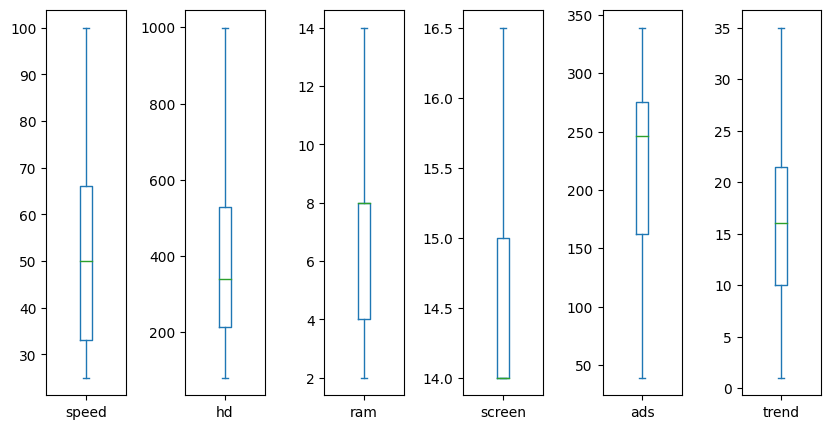

In [20]:
# box plot visualisation
cleandata1.plot(kind = 'box', subplots = True, sharey = False, figsize = (10,5))
plt.subplots_adjust(wspace = 0.75)
plt.show()

In [21]:
## Scaling with MinMaxScaler
scale_pipeline = Pipeline([('scale', MinMaxScaler())])

scale_columntransfer = ColumnTransformer([('scale', scale_pipeline, numeric_features)]) # Skips the transformations for remaining columns

scale = scale_columntransfer.fit(cleandata1)

In [22]:
scaled_data = pd.DataFrame(scale.transform(cleandata1), columns = numeric_features)
scaled_data.describe()

,speed,hd,ram,screen,ads,trend
count,6259.000000,6259.000000,6259.000000,6259.000000,6259.000000,6259.000000
mean,0.360147,0.360673,0.454013,0.224125,0.607670,0.439029
std,0.282103,0.263520,0.324989,0.312291,0.249451,0.231588
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.106667,0.145811,0.166667,0.000000,0.411667,0.264706
50%,0.333333,0.282916,0.500000,0.000000,0.690000,0.441176
75%,0.546667,0.487486,0.500000,0.400000,0.786667,0.602941
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
## Encoding
# Categorical features
encoding_pipeline = Pipeline([('onehot', OneHotEncoder())])

preprocess_pipeline = ColumnTransformer([('categorical', encoding_pipeline, categorical_features)])

clean =  preprocess_pipeline.fit(X)

In [24]:
encode_data = pd.DataFrame(clean.transform(X))
encode_data

,0,1,2,3,4,5
0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
6254,1.0,0.0,1.0,0.0,0.0,1.0
6255,0.0,1.0,0.0,1.0,0.0,1.0
6256,0.0,1.0,1.0,0.0,0.0,1.0
6257,0.0,1.0,1.0,0.0,0.0,1.0


In [25]:
# To get feature names for Categorical columns after Onehotencoding 
encode_data.columns = clean.get_feature_names_out(input_features = X.columns)
encode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6259 entries, 0 to 6258
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   categorical__cd_no        6259 non-null   float64
 1   categorical__cd_yes       6259 non-null   float64
 2   categorical__multi_no     6259 non-null   float64
 3   categorical__multi_yes    6259 non-null   float64
 4   categorical__premium_no   6259 non-null   float64
 5   categorical__premium_yes  6259 non-null   float64
dtypes: float64(6)
memory usage: 293.5 KB


In [26]:
clean_data = pd.concat([scaled_data, encode_data], axis = 1)  # concatenated data will have new sequential index
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6259 entries, 0 to 6258
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   speed                     6259 non-null   float64
 1   hd                        6259 non-null   float64
 2   ram                       6259 non-null   float64
 3   screen                    6259 non-null   float64
 4   ads                       6259 non-null   float64
 5   trend                     6259 non-null   float64
 6   categorical__cd_no        6259 non-null   float64
 7   categorical__cd_yes       6259 non-null   float64
 8   categorical__multi_no     6259 non-null   float64
 9   categorical__multi_yes    6259 non-null   float64
 10  categorical__premium_no   6259 non-null   float64
 11  categorical__premium_yes  6259 non-null   float64
dtypes: float64(12)
memory usage: 586.9 KB


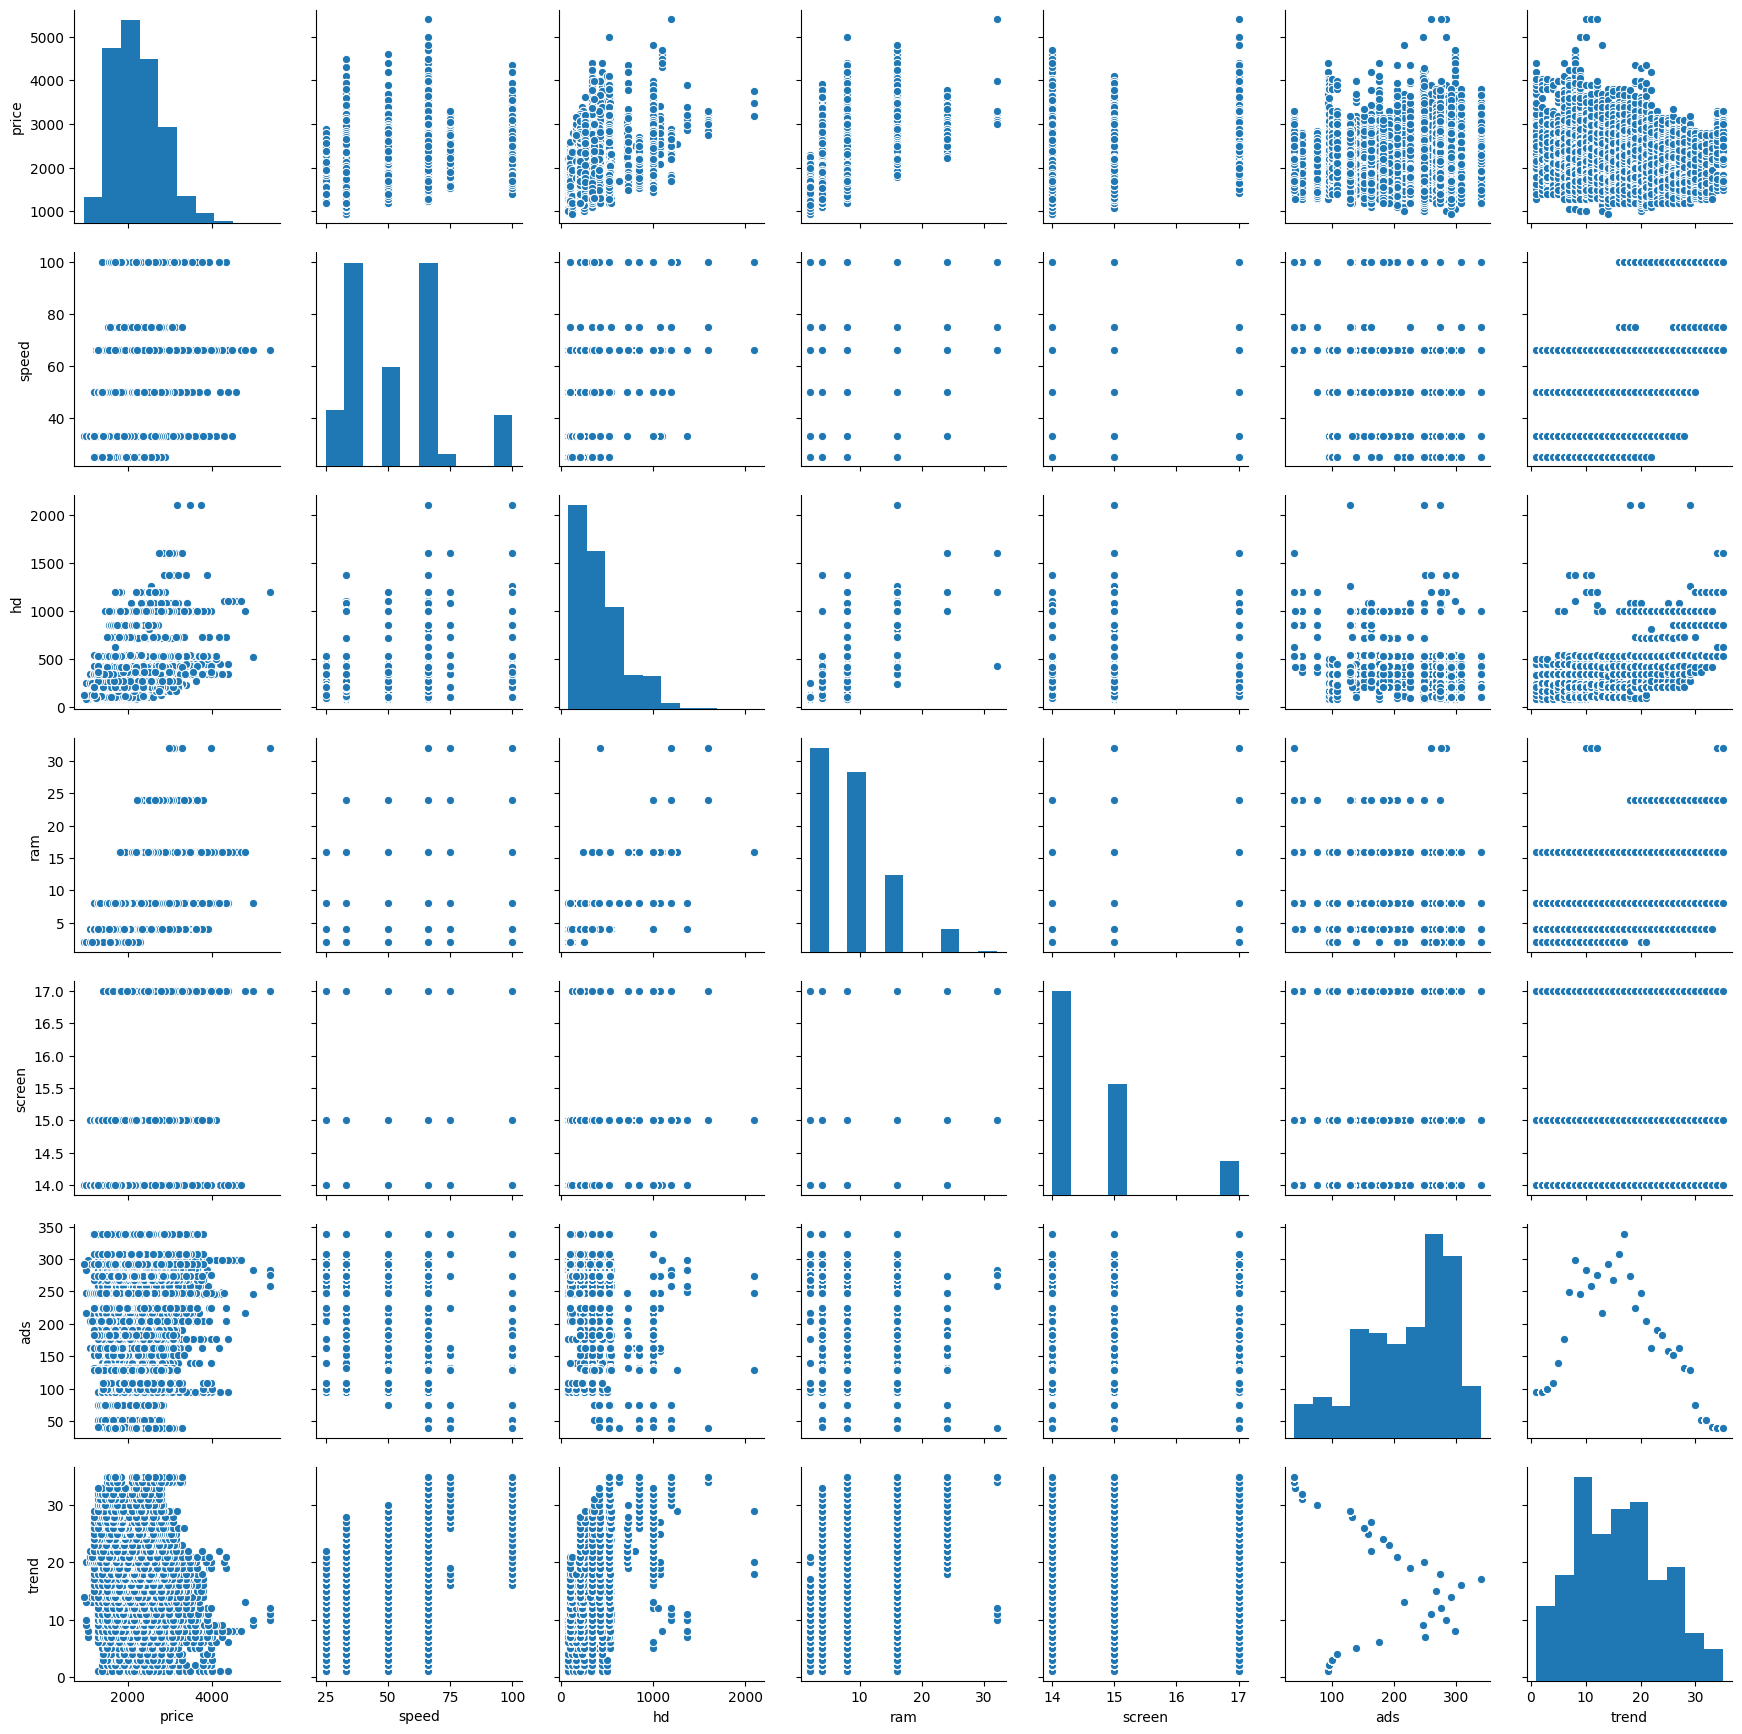

In [27]:
# Multivariate Analysis
sns.pairplot(comp_df) 

In [28]:
# Correlation Analysis on Original Data
orig_df_cor = comp_df.corr()
orig_df_cor

,price,speed,hd,ram,screen,ads,trend
price,1.000000,0.300976,0.430258,0.622748,0.296041,0.054540,-0.199987
speed,0.300976,1.000000,0.372304,0.234760,0.189074,-0.215232,0.405438
hd,0.430258,0.372304,1.000000,0.777726,0.232802,-0.323222,0.577790
ram,0.622748,0.234760,0.777726,1.000000,0.208954,-0.181670,0.276844
screen,0.296041,0.189074,0.232802,0.208954,1.000000,-0.093919,0.188614
ads,0.054540,-0.215232,-0.323222,-0.181670,-0.093919,1.000000,-0.318553
trend,-0.199987,0.405438,0.577790,0.276844,0.188614,-0.318553,1.000000


In [ ]:
# Collinearity between input pairs observed:
# ram - hd : 0.7777
# hd - trend : 0.58

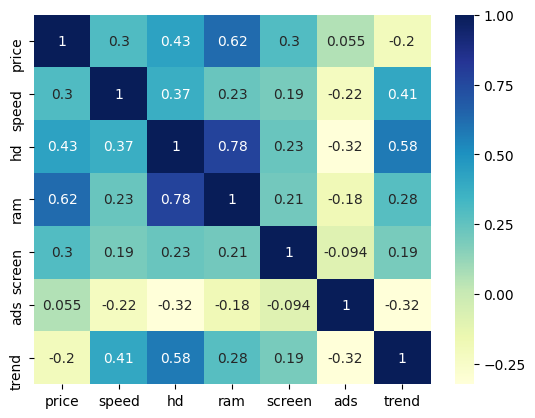

In [29]:
# Heatmap
dataplot = sns.heatmap(orig_df_cor, annot = True, cmap = "YlGnBu")

# Multiple Linear Regression

In [33]:
C = add_constant(clean_data)
C.head()

,const,speed,hd,ram,screen,ads,trend,categorical__cd_no,categorical__cd_yes,categorical__multi_no,categorical__multi_yes,categorical__premium_no,categorical__premium_yes
0,1.0,0.000000,0.000000,0.166667,0.0,0.183333,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.106667,0.005441,0.000000,0.0,0.183333,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.000000,0.097933,0.166667,0.4,0.183333,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.000000,0.097933,0.500000,0.0,0.183333,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.106667,0.282916,1.000000,0.0,0.183333,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [34]:
basemodel = sm.OLS(Y, C).fit()
basemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     2370.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:48:44   Log-Likelihood:                -44069.
No. Observations:                6259   AIC:                         8.816e+04
Df Residuals:                    6249   BIC:                         8.823e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      859.4457      7.073    121.510      0.000     845.580     873.311
speed                      648.3381     13.971     46.406      0.000     620.950     675.726
hd                         922.0323     26.057     35.385      0.000     870.951     973.113
ram                        761.5179     17.623     43.212      0.000     726.971     796.065
screen                     333.0171     11.748     28.347      0.000     309.988     356.047
ads                        176.1988     15.433     11.417      0.000     145.944     206.453
trend                    -1754.1861     21.884    -80.158      0.000   -1797.086   -1711.286
categorical__cd_no         412.5457      4.932     83.639      0.000     402.876     422.215
categorical__cd_yes        446.9000      6.888     64.882      0.000     433.397     460.403
categorical__multi_no      376.9621      6.142     61.374      0.000     364.922     389.003
categorical__multi_yes     482.4836      7.289     66.197      0.000     468.195     496.772
categorical__premium_no    694.6736      8.249     84.216      0.000     678.503     710.844
categorical__premium_yes   164.7721      5.840     28.214      0.000     153.323     176.221
==============================================================================
Omnibus:                      988.336   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2846.654
Skew:                           0.838   Prob(JB):                         0.00
Kurtosis:                       5.848   Cond. No.                     5.20e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.77e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# R-squared : 0.774

In [37]:
# Identify the variable with highest collinearity using 'Variance Inflation Factor(VIF)'
# VIF = 1/(1-R*R)
# Assume VIF > 10 = collinearity

vif = pd.Series([variance_inflation_factor(C.values, i) for i in range(C.shape[1])], index = C.columns)
vif

const                       0.000000
speed                       1.269912
hd                          3.854617
ram                         2.681628
screen                      1.100338
ads                         1.211660
trend                       2.099842
categorical__cd_no               inf
categorical__cd_yes              inf
categorical__multi_no            inf
categorical__multi_yes           inf
categorical__premium_no          inf
categorical__premium_yes         inf
dtype: float64

In [ ]:
# column on Index 2 shows highest VIF 
# hd is showing high VIF value

In [38]:
# Drop colinearity variable - variable 'hd'
clean_data1 = clean_data.drop('hd', axis = 1)
clean_data1.columns

Index(['speed', 'ram', 'screen', 'ads', 'trend', 'categorical__cd_no',
       'categorical__cd_yes', 'categorical__multi_no',
       'categorical__multi_yes', 'categorical__premium_no',
       'categorical__premium_yes'],
      dtype='object')

In [39]:
# Build a model on dataset
basemodel2 = sm.OLS(Y, clean_data1).fit()
basemodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     2091.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:52:50   Log-Likelihood:                -44641.
No. Observations:                6259   AIC:                         8.930e+04
Df Residuals:                    6250   BIC:                         8.936e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
speed                      672.3681     15.288     43.981      0.000     642.399     702.337
ram                       1192.4140     13.956     85.442      0.000    1165.056    1219.772
screen                     346.2674     12.863     26.919      0.000     321.051     371.484
ads                         88.0978     16.686      5.280      0.000      55.388     120.808
trend                    -1364.9012     20.725    -65.858      0.000   -1405.529   -1324.273
categorical__cd_no         667.8678      6.761     98.787      0.000     654.615     681.121
categorical__cd_yes        752.9361      9.618     78.284      0.000     734.081     771.791
categorical__multi_no      680.4025      8.095     84.055      0.000     664.534     696.271
categorical__multi_yes     740.4014      9.789     75.637      0.000     721.212     759.591
categorical__premium_no    962.0314     11.026     87.252      0.000     940.417     983.646
categorical__premium_yes   458.7726      7.348     62.437      0.000     444.368     473.177
==============================================================================
Omnibus:                     1341.220   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4714.009
Skew:                           1.053   Prob(JB):                         0.00
Kurtosis:                       6.694   Cond. No.                     1.57e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.83e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# R-squared: 0.728 reduced
# eigenvalue is 7.83e-29 indicates there is still strong multicollinearity problem.

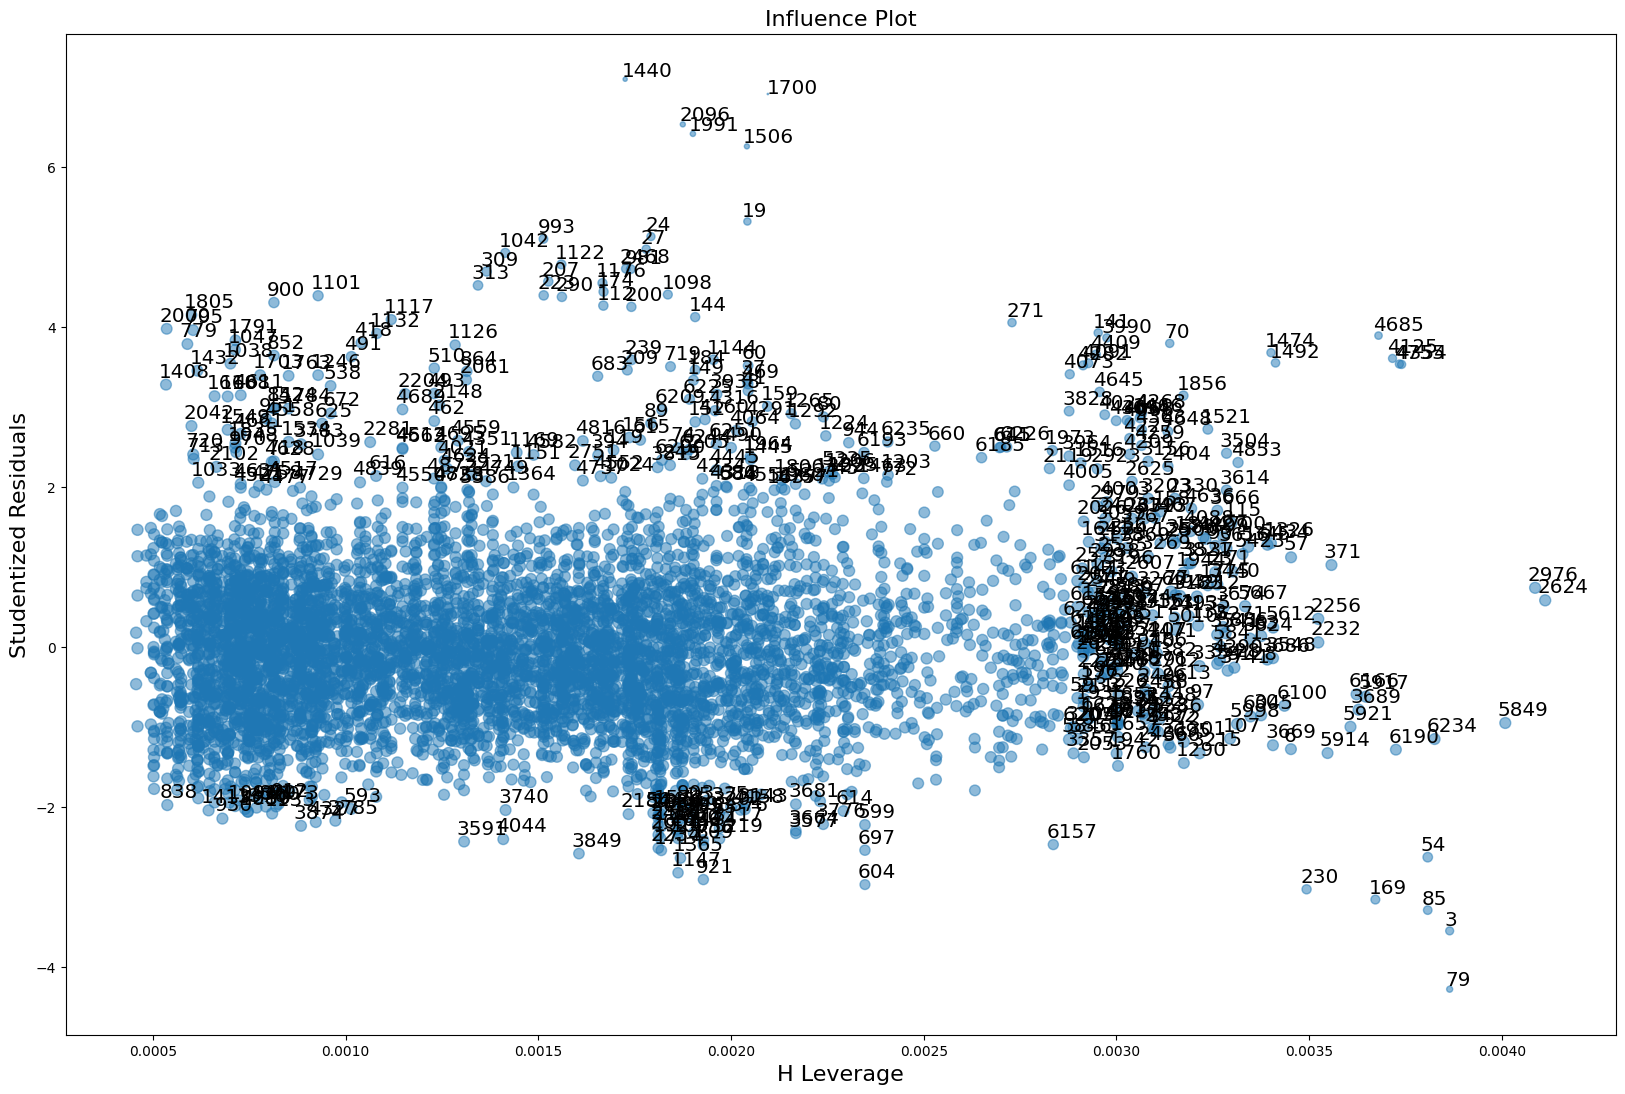

In [40]:
# Tune the model by verifying for influential observations
plt.rcParams["figure.figsize"] = (20,13)
sm.graphics.influence_plot(basemodel2, size=1, plot_alpha=0.5)
plt.show()

In [41]:
# Remove few influential observations to tune the model and verify 
clean_data1_new = clean_data1.drop(clean_data1.index[[1440, 1700, 79,3,6157, 900, 1101, 1048, 1610, 1506, 2042, 1835, 1524, 2102, 2282, 5987, 6167, 604, 599]])
Y_new = Y.drop(Y.index[[1440, 1700, 79,3,6157, 900, 1101, 1048, 1610, 1506, 2042, 1835, 1524, 2102, 2282, 5987, 6167, 604, 599]])

In [42]:
# Build model on new dataset
basemodel3 = sm.OLS(Y_new, clean_data1_new).fit()
basemodel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     2164.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:54:37   Log-Likelihood:                -44372.
No. Observations:                6240   AIC:                         8.876e+04
Df Residuals:                    6231   BIC:                         8.882e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
speed                      666.1831     14.981     44.467      0.000     636.814     695.552
ram                       1191.8821     13.676     87.155      0.000    1165.073    1218.691
screen                     340.0087     12.617     26.949      0.000     315.275     364.742
ads                         73.6481     16.382      4.496      0.000      41.534     105.762
trend                    -1362.5671     20.334    -67.009      0.000   -1402.429   -1322.705
categorical__cd_no         671.9965      6.641    101.190      0.000     658.978     685.015
categorical__cd_yes        759.3333      9.441     80.428      0.000     740.826     777.841
categorical__multi_no      684.1252      7.945     86.112      0.000     668.551     699.699
categorical__multi_yes     747.2047      9.607     77.776      0.000     728.371     766.038
categorical__premium_no    972.8542     10.854     89.632      0.000     951.577     994.131
categorical__premium_yes   458.4757      7.194     63.733      0.000     444.374     472.578
==============================================================================
Omnibus:                     1130.265   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3216.189
Skew:                           0.957   Prob(JB):                         0.00
Kurtosis:                       5.950   Cond. No.                     1.54e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.13e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# R-squared: 0.735
# eigenvalue is  8.13e-29 indicates there is still strong multicollinearity problem.

# Regularization Techniques: LASSO, RIDGE and Elasticnet Regression

## LASSO MODEL

In [44]:
lasso = Lasso(alpha = 0.13, normalize = True)

In [45]:
lasso.fit(clean_data1_new, Y_new)

Lasso(alpha=0.13, normalize=True)

In [46]:
# Coefficient values for all independent variables#
lasso.coef_

array([ 6.10569562e+02,  1.16540962e+03,  3.09228064e+02,  4.78440869e+01,
       -1.25337950e+03, -6.46039666e+01,  8.65590356e-15, -3.11943642e+01,
        1.66114175e-14,  4.60616032e+02, -4.46485332e-13])

In [47]:
lasso.intercept_

array([1937.31716335])

<BarContainer object of 11 artists>

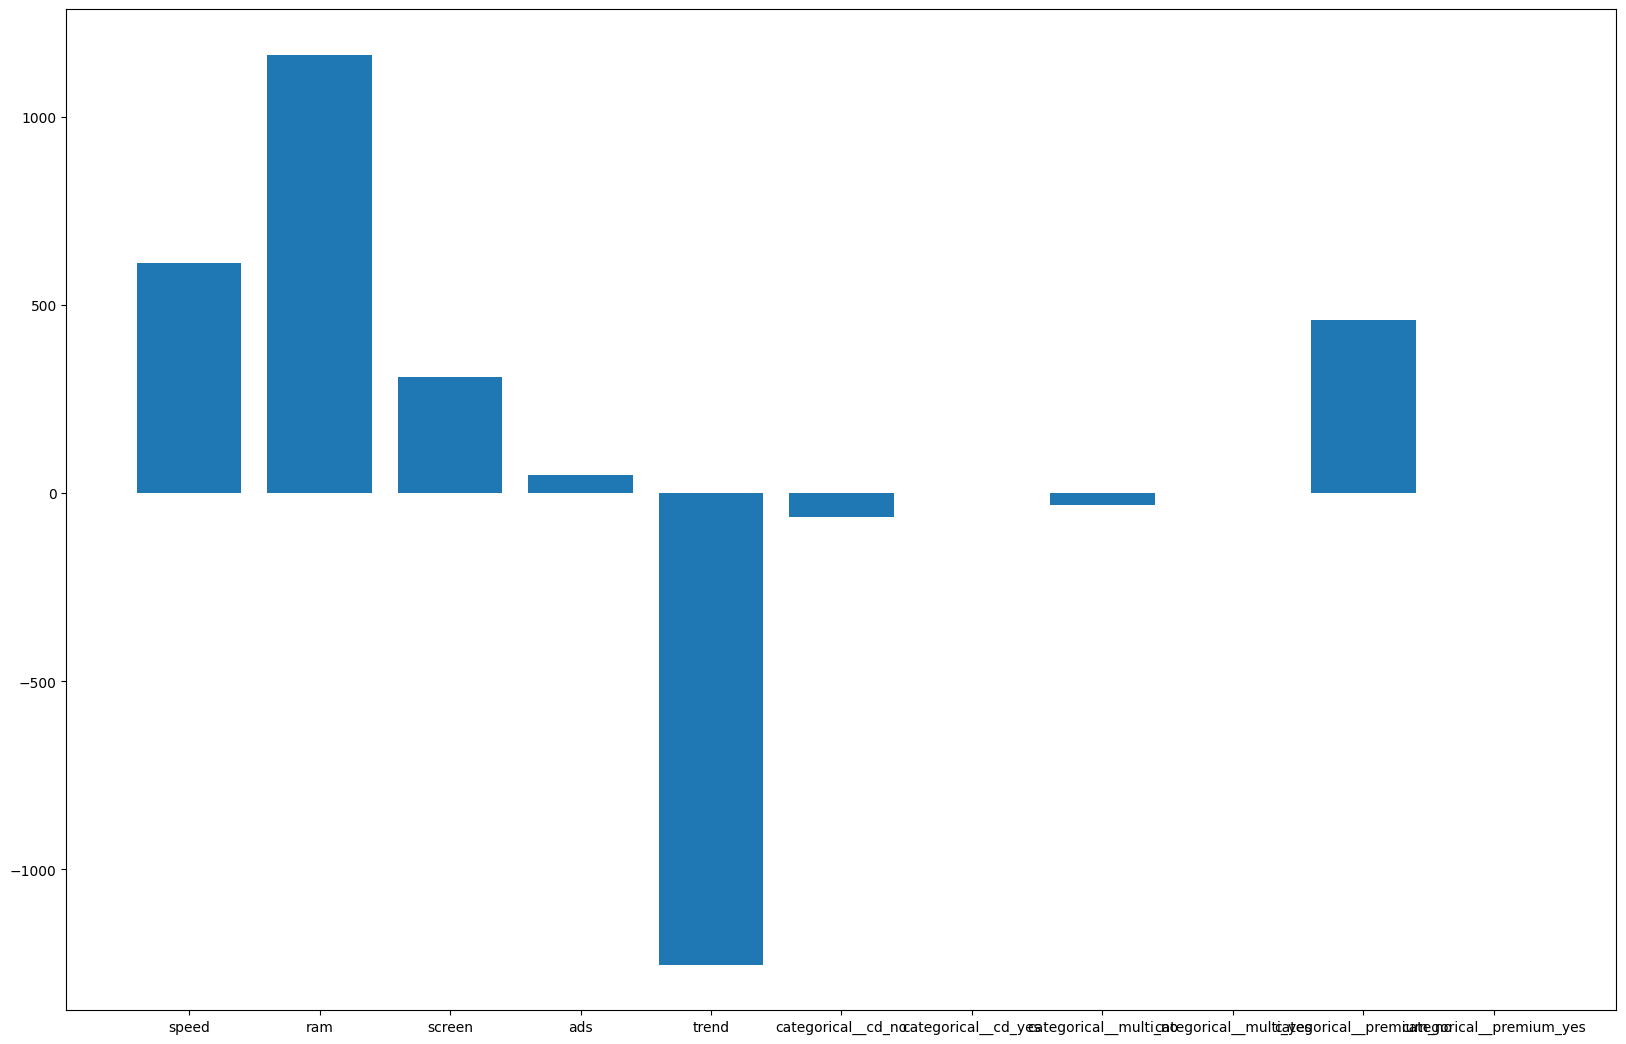

In [48]:
plt.bar(height = pd.Series(lasso.coef_), x = pd.Series(clean_data1_new.columns))

In [49]:
# Create a function called lasso,
pred_lasso = lasso.predict(clean_data1_new)

In [51]:
# Adjusted r-square
s1 = lasso.score(clean_data1_new, Y_new)
s1

0.7320881574040965

In [53]:
# RMSE
np.sqrt(np.mean((pred_lasso - np.array(Y_new['price']))**2))

298.2870338897947

## RIDGE REGRESSION

In [55]:
rm = Ridge(alpha = 0.13, normalize = True)

In [56]:
rm.fit(clean_data1_new, Y_new)

Ridge(alpha=0.13, normalize=True)

In [57]:
# Coefficients values for all the independent vairbales
rm.coef_

array([[  554.75807883,  1028.56561551,   318.15851247,    91.11901591,
        -1097.7407483 ,   -46.78798064,    46.78798064,   -14.16069678,
           14.16069678,   219.11319213,  -219.11319213]])

In [58]:
result = rm.coef_.flatten()

In [59]:
rm.intercept_

array([2096.19198237])

<BarContainer object of 11 artists>

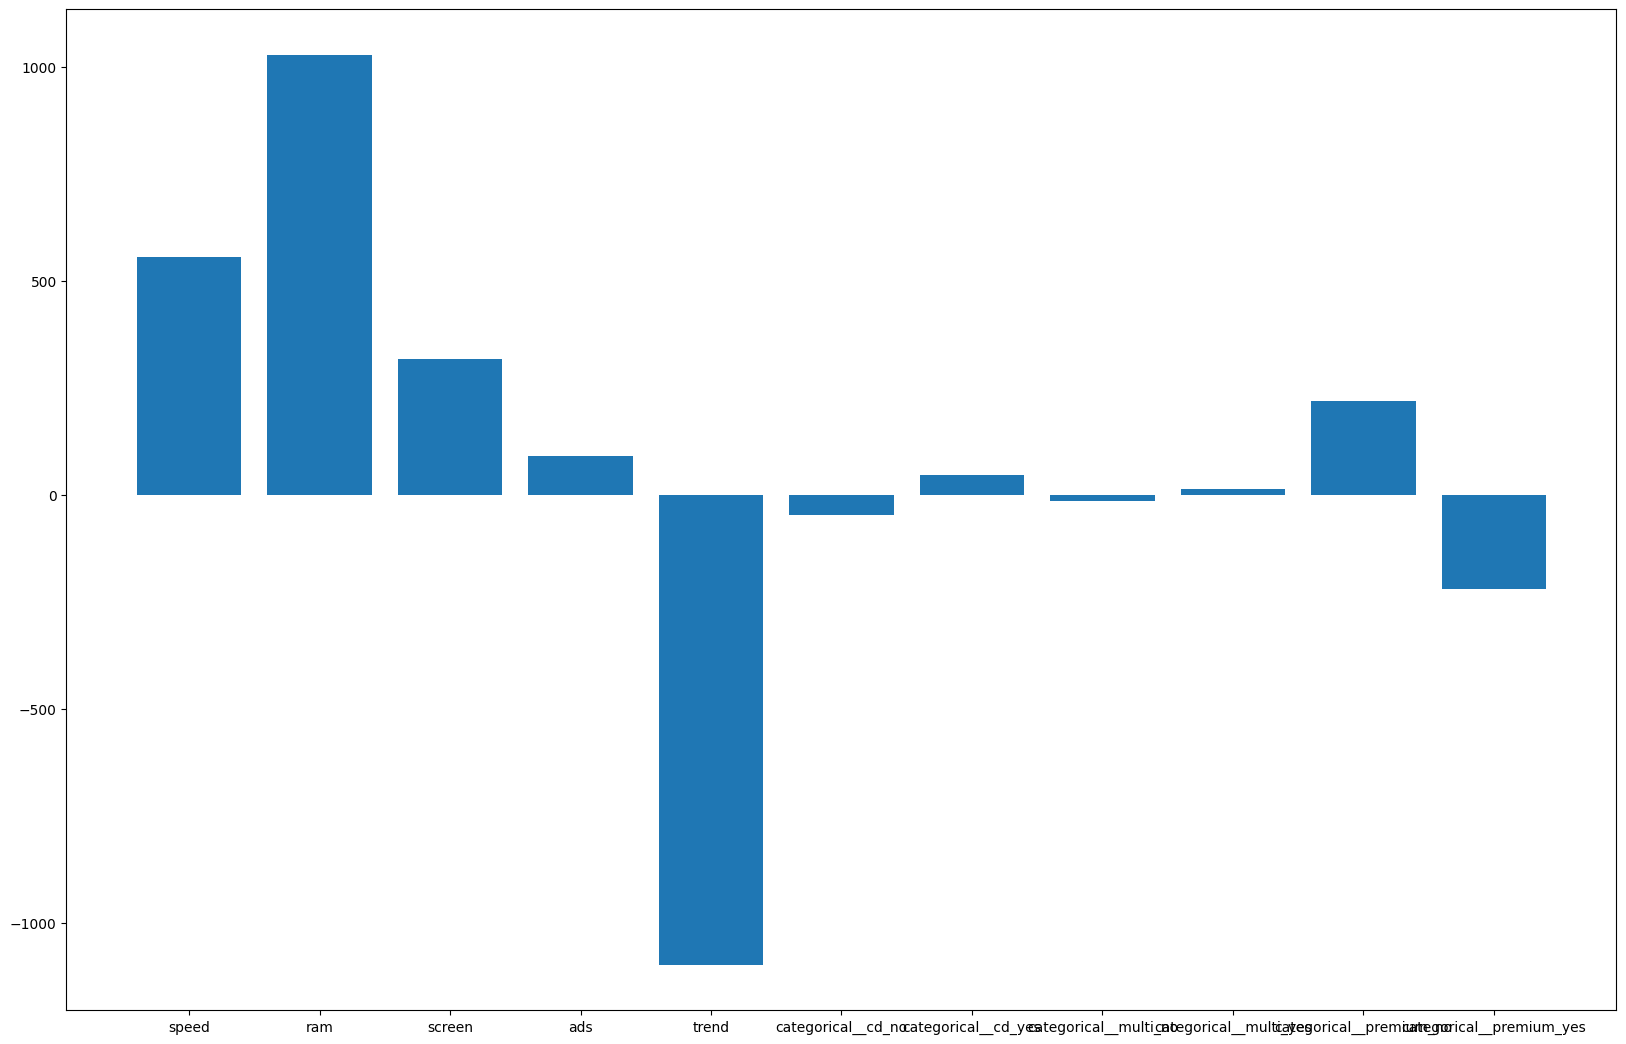

In [60]:
plt.bar(height = pd.Series(result), x = pd.Series(clean_data1_new.columns))

In [61]:
pred_rm = rm.predict(clean_data1_new)

In [63]:
# Adjusted r-square
s2 = rm.score(clean_data1_new, Y_new.price)
s2

0.7195378007656759

In [64]:
# RMSE
np.sqrt(np.mean((pred_rm - np.array(Y_new['price']))**2))

716.7003295936662

## ELASTIC NET REGRESSION

In [66]:
enet = ElasticNet(alpha= 0.13)

In [67]:
enet.fit(clean_data1_new, Y_new.price)

ElasticNet(alpha=0.13)

In [68]:
# Coefficients values for all the independent vairbales
enet.coef_

array([ 282.11768488,  680.52352863,  234.46105982,   88.71308072,
       -432.50577015,  -47.78977689,   47.64355398,   18.01013017,
        -18.02257469,  133.31007391, -133.31244536])

In [69]:
enet.intercept_

1988.1334261374884

<BarContainer object of 11 artists>

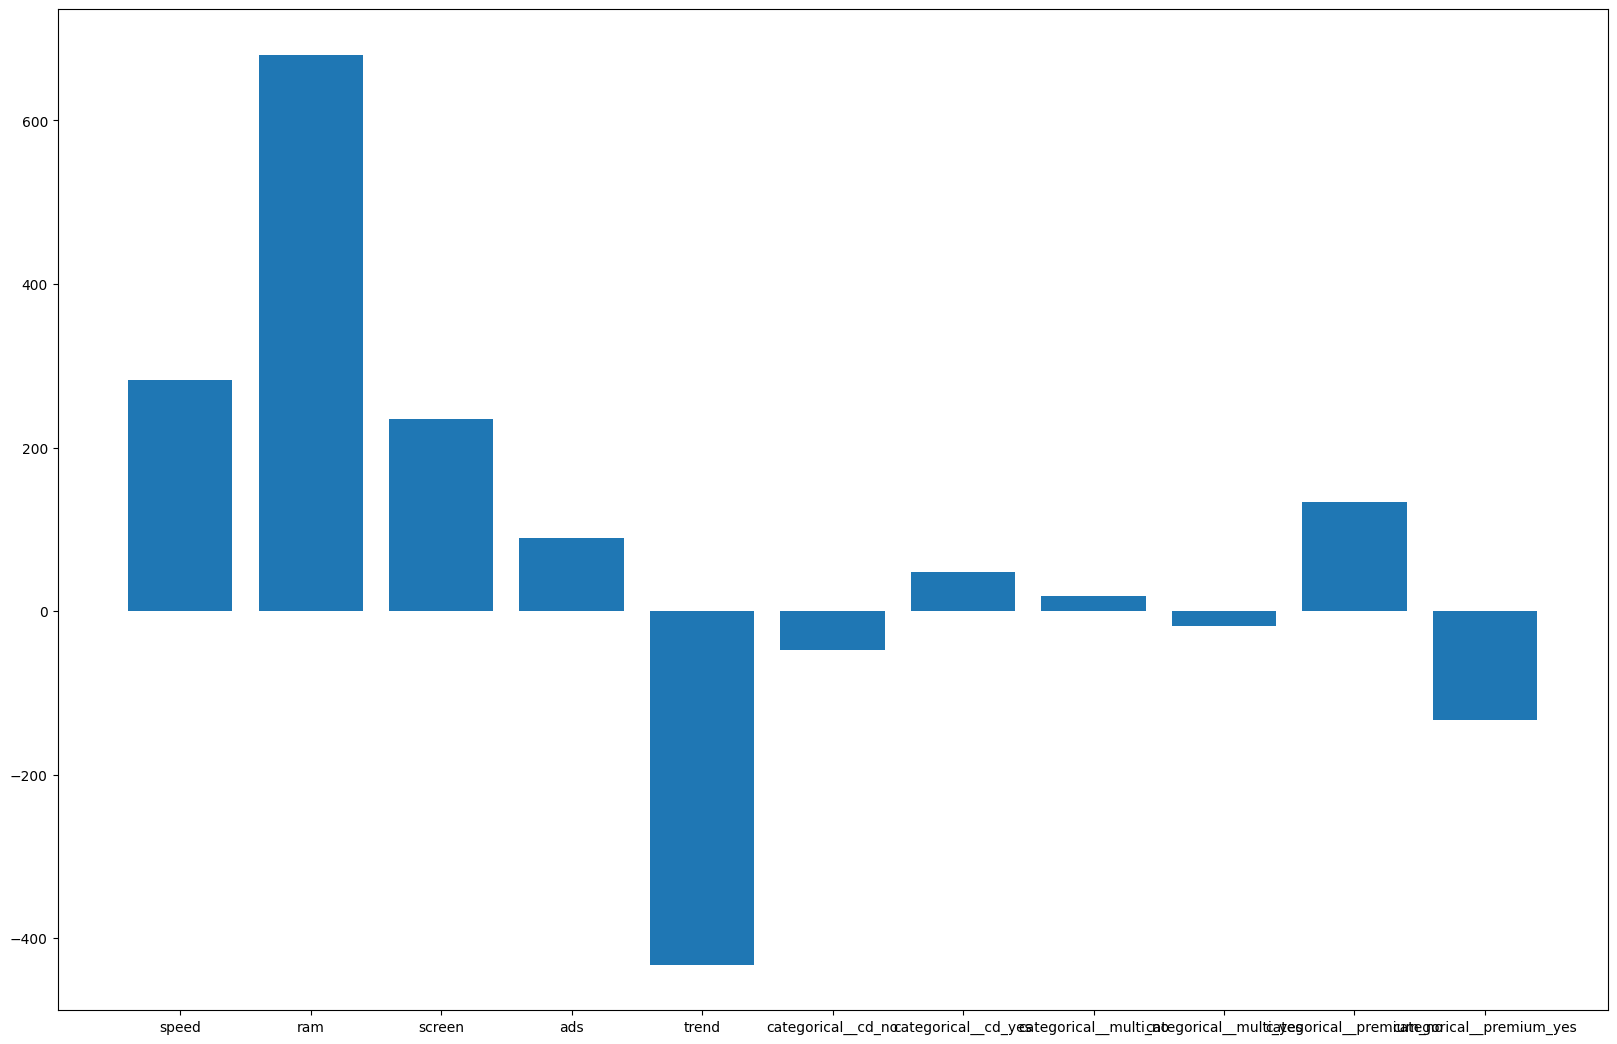

In [70]:
plt.bar(height = pd.Series(enet.coef_), x = pd.Series(clean_data1_new.columns))

In [71]:
pred_enet = enet.predict(clean_data1_new)

In [73]:
# Adjusted r-square
s3 = enet.score(clean_data1_new, Y_new.price)
s3

0.5562331535818235

In [74]:
# RMSE
np.sqrt(np.mean((pred_enet - np.array(Y_new.price))**2))

383.8979973430772

## Lasso Regression with GridSearchCV

In [76]:
lasso = Lasso()

In [77]:
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5 ,10, 20]}

In [78]:
lasso_reg = GridSearchCV(lasso, parameters, scoring = 'r2', cv = 5)

In [79]:
lasso_reg.fit(clean_data1_new, Y_new.price)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='r2')

In [80]:
lasso_reg.best_params_

{'alpha': 1}

In [81]:
lasso_reg.best_score_

0.6821341634857297

In [82]:
lasso_pred = lasso_reg.predict(clean_data1_new)

In [84]:
# Adjusted r-square#
s4 = lasso_reg.score(clean_data1_new, Y_new.price)
s4

0.7349348347678379

In [85]:
# RMSE
np.sqrt(np.mean((lasso_pred - np.array(Y_new.price))**2))

296.6980884623018

## Ridge Regression with GridSearchCV

In [86]:
ridge = Ridge()

In [87]:
ridge_reg = GridSearchCV(ridge, parameters, scoring = 'r2', cv = 5)

In [88]:
ridge_reg.fit(clean_data1_new, Y_new.price)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='r2')

In [89]:
ridge_reg.best_params_

{'alpha': 1}

In [90]:
ridge_reg.best_score_

0.6778902858209361

In [91]:
ridge_pred = ridge_reg.predict(clean_data1_new)

In [92]:
# Adjusted r-square#
s5 = ridge_reg.score(clean_data1_new, Y_new.price)
s5

0.7352951662819256

In [93]:
# RMSE
np.sqrt(np.mean((ridge_pred - np.array(Y_new.price))**2))

296.4963531088235

## ElasticNet Regression with GridSearchCV

In [94]:
enet = ElasticNet()

In [95]:
enet_reg = GridSearchCV(enet, parameters, scoring = 'r2', cv = 5)

In [96]:
enet_reg.fit(clean_data1_new, Y_new.price)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='r2')

In [97]:
enet_reg.best_params_

{'alpha': 0.0001}

In [98]:
enet_reg.best_score_

0.6777537428716143

In [99]:
enet_pred = enet_reg.predict(clean_data1_new)

In [100]:
# Adjusted r-square
s6 = enet_reg.score(clean_data1_new, Y_new.price)
s6

0.7353014189905132

In [101]:
# RMSE
np.sqrt(np.mean((enet_pred - np.array(Y_new.price))**2))

296.49285125316163

In [102]:
scores_all = pd.DataFrame({'models':['Lasso', 'Ridge', 'Elasticnet', 'Grid_lasso', 'Grid_ridge', 'Grid_elasticnet'], 'Scores':[s1, s2, s3, s4, s5, s6]})
scores_all

,models,Scores
0,Lasso,0.732088
1,Ridge,0.719538
2,Elasticnet,0.556233
3,Grid_lasso,0.734935
4,Grid_ridge,0.735295
5,Grid_elasticnet,0.735301


In [ ]:
# 'Best score obtained is for Gridsearch elasticnet Regression'

In [103]:
np.sort(scores_all.Scores)

array([0.55623315, 0.7195378 , 0.73208816, 0.73493483, 0.73529517,
       0.73530142])